In [2]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=: 1


In [133]:
import random 

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
from collections import namedtuple
from itertools import count
from PIL import Image
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

## TODO

    get env states from img

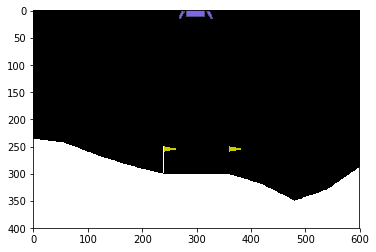

In [97]:
# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("LunarLander-v2").env

env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"));

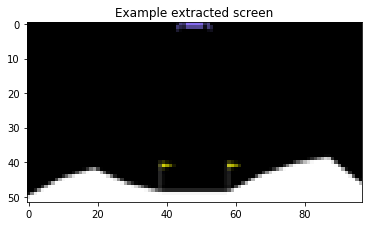

In [319]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(65, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_lander_location(screen, last_X, last_Y):    
    R = screen[0]
    G = screen[1]
    B = screen[2]
    line = 0
    coоrdinates = [[],[]]
    for line_r, line_g, line_b in zip(R, G, B):
        line += 1
        column = 0
        for pixel_r, pixel_g, pixel_b in zip(line_r, line_g, line_b):
            column +=1
            if  (round(pixel_r.item(),1) == 0.5) & (round(pixel_g.item(),1) == 0.4) & (round(pixel_b.item(),1) == 0.9):
                coоrdinates[0].append(line)
                coоrdinates[1].append(column)
    if(len(coоrdinates)>0):
        if(not np.isnan(np.array(coоrdinates[0]).mean())):
            Y = int(np.array(coоrdinates[0]).mean())
            X = int(np.array(coоrdinates[1]).mean())
            out_of_screen = False
        else:
            X = last_X
            Y = last_Y
            out_of_screen = True
    else:
        X = last_X
        Y = last_Y
        out_of_screen = True
    return (X, Y, out_of_screen)



def get_screen(last_X, last_Y):
    
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    
    
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    # Resize, and add a batch dimension (BCHW)
    
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    screen = resize(screen)
    
    _, screen_height, screen_width = screen.shape
    screen = screen[:, :int(screen_height * 0.8)]
    _, screen_height, screen_width = screen.shape
    
    X, Y , out_of_screen = get_lander_location(screen, last_X, last_Y)

#     if(X<24):
#         slice_width = slice(None,48)
#     elif(X>(screen_width-24)):
#         slice_width = slice(48,96)
#     else:
#         slice_width = slice(X-24,X+24)
        
#     screen = screen[:, :, slice_width]
    
    return (screen, X, Y, out_of_screen)


env.reset()

screen, last_X, last_Y, out_of_screen = get_screen(0, 0)
plt.figure()
plt.imshow(screen.cpu().unsqueeze(0).squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

# Flags

In [320]:
def get_flag_location(screen):  
    R = screen[0]
    G = screen[1]
    B = screen[2]
    line = 0
    coоrdinates = [[],[]]
    for line_r, line_g, line_b in zip(R, G, B):
        line += 1
        column = 0
        for pixel_r, pixel_g, pixel_b in zip(line_r, line_g, line_b):
            column +=1
            if  (round(pixel_r.item(),1) == 0.8) & (round(pixel_g.item(),1) == 0.8) & (round(pixel_b.item(),1) == 0.):
                coоrdinates[0].append(line)
                coоrdinates[1].append(column)
                
    if(len(coоrdinates)>0):
        if(not np.isnan(np.array(coоrdinates[0]).mean())):
            Y = int(np.array(coоrdinates[0]).mean())
            X = int(np.array(coоrdinates[1]).mean())
            out_of_screen = False
        else:
            X = '='
            Y = '='
            out_of_screen = True
    else:
        X = '='
        Y = '='
        out_of_screen = True
    return (X, Y, out_of_screen)

In [321]:
X, Y, out_of_screen

(40, 42, False)

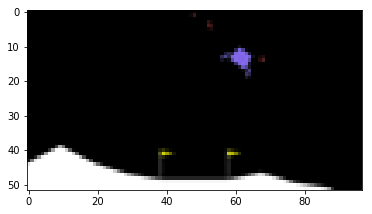

In [383]:
image = screen.cpu().unsqueeze(0).squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(image);

    расстояние между флагами 20 пикселей, высота флага 10 пикселей - > идеальная координата посадки: 
    x_1 + 10, y_1 + 10

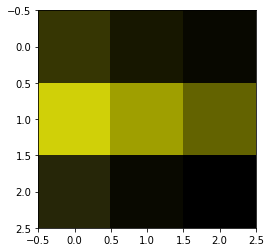

In [384]:
plt.imshow(image[40:43, 39:42]); # x_1, y_1 -> 42, 40

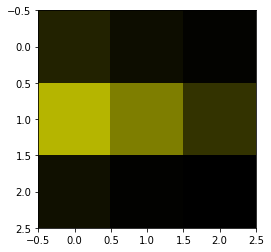

In [385]:
plt.imshow(image[40:43, 59:62]); # x_2, y_2 -> 62, 40

# Lander

    получить кординаты - get_screen()

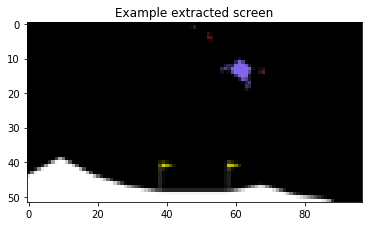

In [381]:
_, reward, done, _ = env.step(random.choice([0,1,2,3]))

screen, last_X, last_Y, out_of_screen = get_screen(0, 0)
plt.figure()
plt.imshow(screen.cpu().unsqueeze(0).squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [382]:
last_X, last_Y

(62, 14)

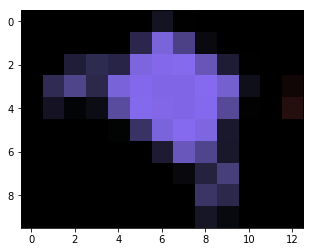

In [396]:
plt.imshow(image[10:20, 55:68]);

    наклон lander'a

In [428]:
env.reset() 

array([-1.1836052e-03,  1.4049755e+00, -1.1989480e-01, -2.6420107e-01,
        1.3782149e-03,  2.7157951e-02,  0.0000000e+00,  0.0000000e+00],
      dtype=float32)

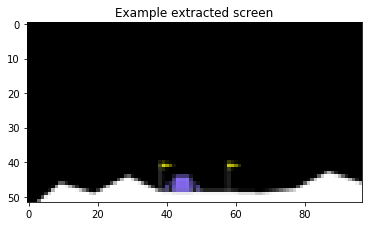

In [517]:
_, reward, done, _ = env.step(random.choice([0]))
screen, last_X, last_Y, out_of_screen = get_screen(0, 0)
plt.figure()
plt.imshow(screen.cpu().unsqueeze(0).squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()
image = screen.cpu().unsqueeze(0).squeeze(0).permute(1, 2, 0).numpy()

In [560]:
image.shape

(52, 97, 3)

In [518]:
last_X, last_Y

(45, 47)

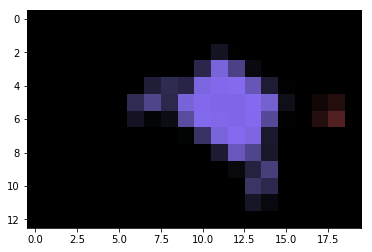

In [427]:
plt.imshow(image[8:21, 50:70]);

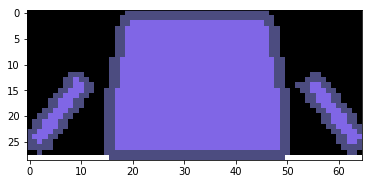

In [558]:
plt.imshow(screen[273:302, 245:310]);

In [563]:
abs(273-302), abs(245-310)

(29, 65)